In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load dataset
df = pd.read_csv("creditcard.csv")

X = df.drop(columns=['Class'])
y = df['Class']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
def build_dnn():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Remove NaN or infinite values from target
y = y.replace([np.inf, -np.inf], np.nan)
y = y.dropna()

# IMPORTANT: align X with cleaned y
X_scaled = X_scaled[y.index]

# Convert target to integer
y = y.astype(int)

# Explicitly define classes
classes = np.array([0, 1])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

# Convert to dictionary (required by Keras)
class_weights = dict(zip(classes, class_weights))

print("Class Weights:", class_weights)


Class Weights: {np.int64(0): np.float64(0.5021837728876197), np.int64(1): np.float64(114.98076923076923)}


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4769 - loss: 0.9933
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5038 - loss: 0.7295
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5252 - loss: 0.6622
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5364 - loss: 0.5072 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5834 - loss: 0.4718
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5925 - loss: 0.5120
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6161 - loss: 0.4618
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6306 - loss: 0.4339
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6587 - loss: 0.4346
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6765 - loss: 0.4274


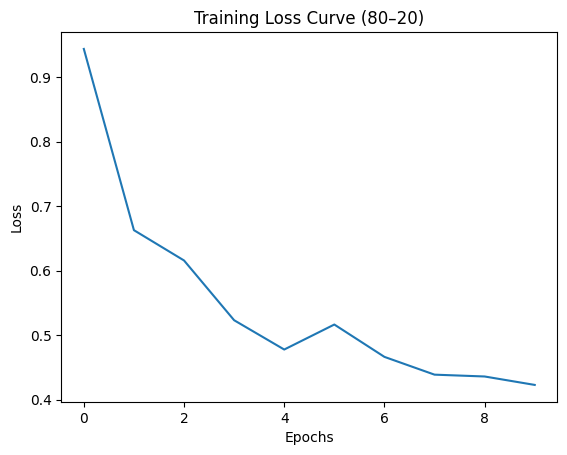

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2063  319]
 [   1    9]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2382
           1       0.03      0.90      0.05        10

    accuracy                           0.87      2392
   macro avg       0.51      0.88      0.49      2392
weighted avg       1.00      0.87      0.92      2392

ROC-AUC: 0.9030856423173804
PR-AUC: 0.7873123161515632


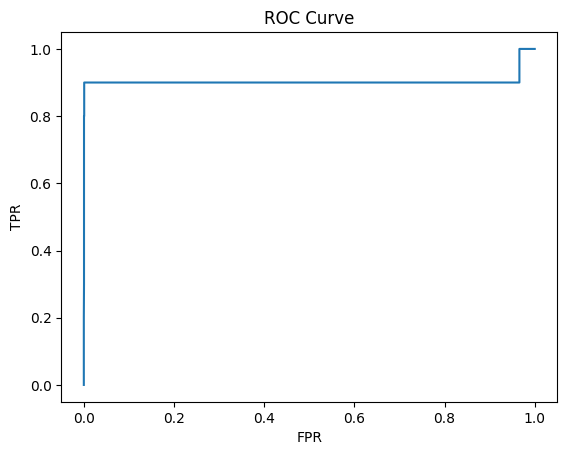

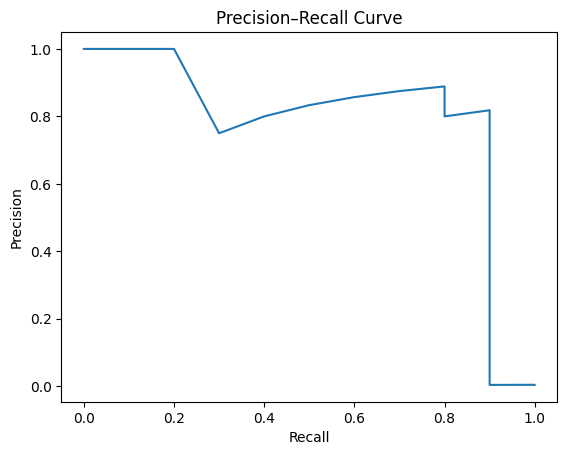

In [14]:
#EXPERIMENT 1 — 80–20 SPLIT (NO VALIDATION)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

model = build_dnn()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=2048,
    class_weight=class_weights,
    verbose=1
)
plt.plot(history.history['loss'])
plt.title("Training Loss Curve (80–20)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5216 - loss: 2.8240
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5245 - loss: 1.7130
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5178 - loss: 1.7642
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5312 - loss: 0.6480
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5213 - loss: 0.7157
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5354 - loss: 0.7685
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5530 - loss: 0.5487
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5594 - loss: 0.6476
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5822 - loss: 0.5161
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5908 - loss: 0.5134


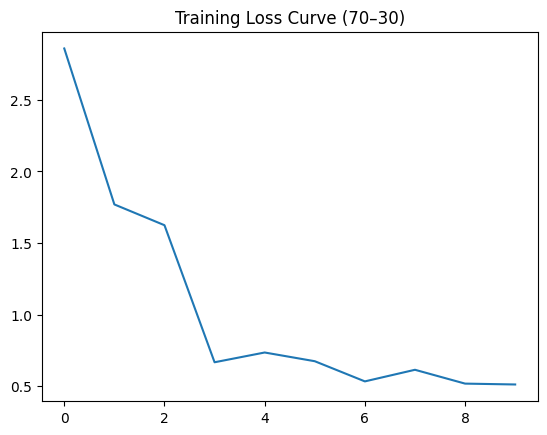

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[3270  302]
 [   1   15]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3572
           1       0.05      0.94      0.09        16

    accuracy                           0.92      3588
   macro avg       0.52      0.93      0.52      3588
weighted avg       1.00      0.92      0.95      3588

ROC-AUC: 0.9377099664053753
PR-AUC: 0.8202339908770209


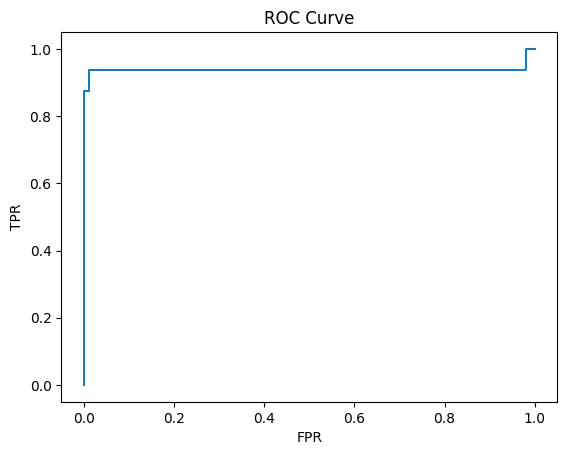

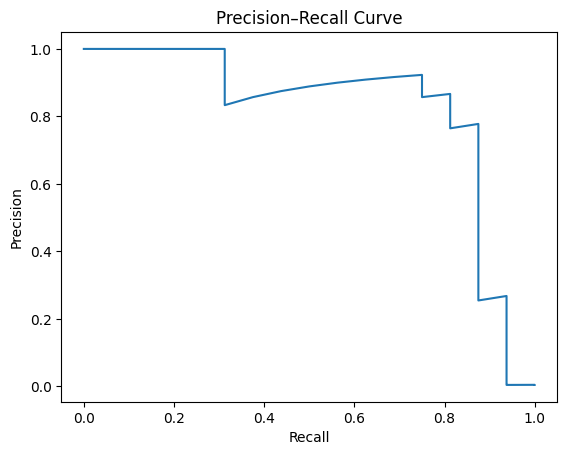

In [15]:
#EXPERIMENT 2 — 70–30 SPLIT (NO VALIDATION)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

model = build_dnn()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=2048,
    class_weight=class_weights,
    verbose=1
)

plt.plot(history.history['loss'])
plt.title("Training Loss Curve (70–30)")
plt.show()
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.4877 - loss: 1.1009 - val_accuracy: 0.9013 - val_loss: 0.6076
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5019 - loss: 0.6424 - val_accuracy: 0.9235 - val_loss: 0.5872
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5169 - loss: 0.5845 - val_accuracy: 0.9377 - val_loss: 0.5717
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5274 - loss: 0.7139 - val_accuracy: 0.9461 - val_loss: 0.5598
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5408 - loss: 0.8244 - val_accuracy: 0.9540 - val_loss: 0.5485
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5635 - loss: 0.5095 - val_accuracy: 0.9590 - val_loss: 0.5381
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5785 - loss: 0.4888 - val_accuracy: 0.9628 - val_loss: 0.5288
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5893 - loss: 0.4853 - val_accuracy: 0.9632 - val_loss: 0.5200
Epoch 9/20

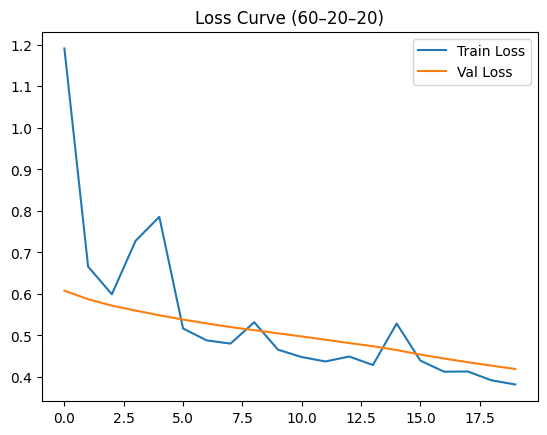

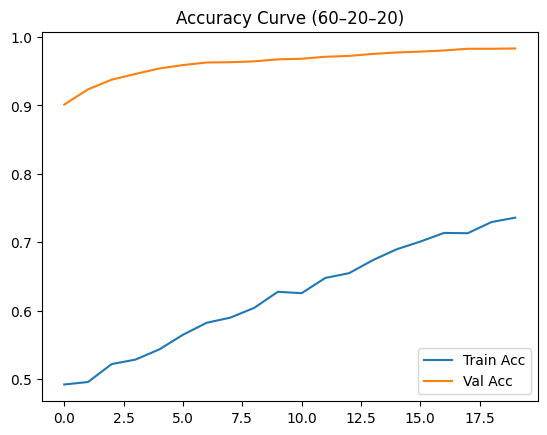

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2334   48]
 [   1    9]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2382
           1       0.16      0.90      0.27        10

    accuracy                           0.98      2392
   macro avg       0.58      0.94      0.63      2392
weighted avg       1.00      0.98      0.99      2392

ROC-AUC: 0.9821998320738875
PR-AUC: 0.8202010916681588


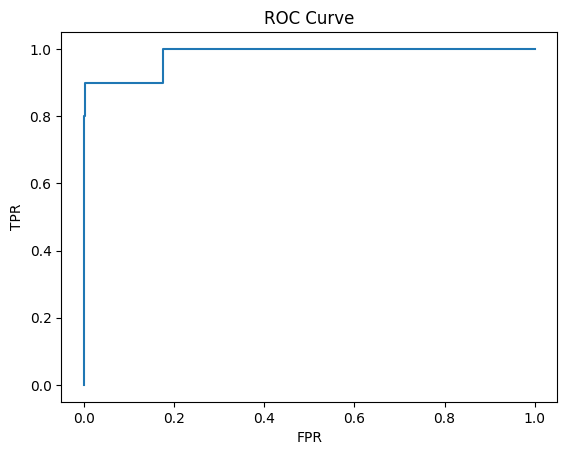

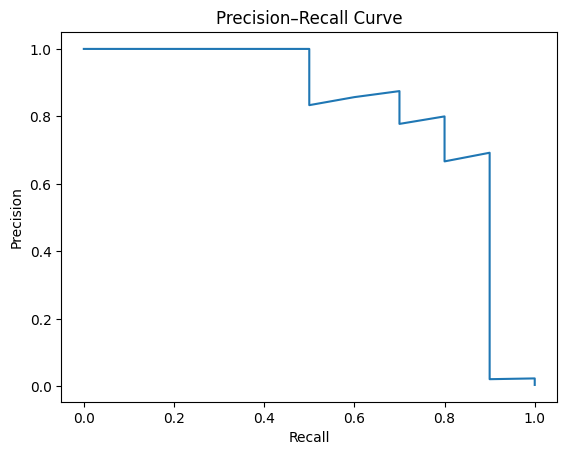

In [17]:
#EXPERIMENT 3 — 60–20–20 (WITH VALIDATION)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

model = build_dnn()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve (60–20–20)")
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve (60–20–20)")
plt.show()
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.4585 - loss: 0.8281 - val_accuracy: 0.7121 - val_loss: 0.6974
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4905 - loss: 0.6293 - val_accuracy: 0.7272 - val_loss: 0.6942
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4910 - loss: 0.5618 - val_accuracy: 0.7306 - val_loss: 0.6923
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5230 - loss: 0.5575 - val_accuracy: 0.7440 - val_loss: 0.6889
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5415 - loss: 0.5705 - val_accuracy: 0.7613 - val_loss: 0.6838
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5668 - loss: 0.4758 - val_accuracy: 0.7725 - val_loss: 0.6799
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5782 - loss: 0.4834 - val_accuracy: 0.7865 - val_loss: 0.6751
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5968 - loss: 0.5010 - val_accuracy: 0.7999 - val_loss: 0.6690
Epoch 9/20

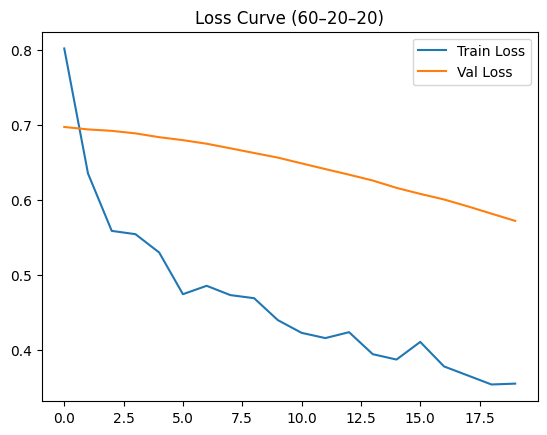

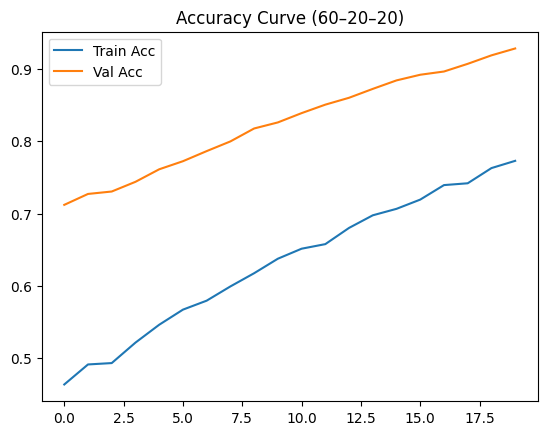

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
[[1653  133]
 [   1    7]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1786
           1       0.05      0.88      0.09         8

    accuracy                           0.93      1794
   macro avg       0.52      0.90      0.53      1794
weighted avg       1.00      0.93      0.96      1794

ROC-AUC: 0.9716545352743562
PR-AUC: 0.8055190041583055


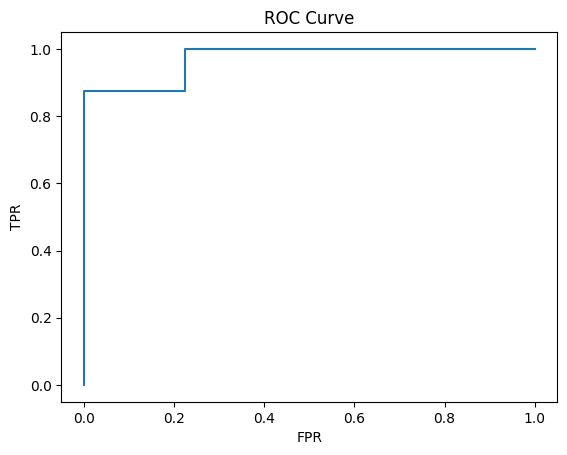

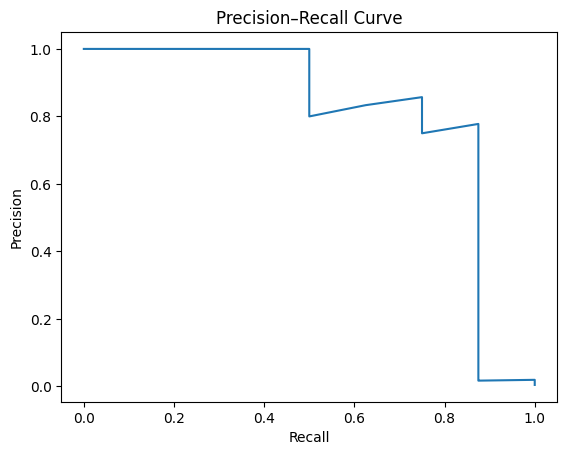

In [18]:
#EXPERIMENT 4 — 70–15–15 (WITH VALIDATION)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)

model = build_dnn()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve (60–20–20)")
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve (60–20–20)")
plt.show()
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_scores = []
pr_scores = []

for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = build_dnn()
    model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=2048,
        class_weight=class_weights,
        verbose=0
    )

    y_prob = model.predict(X_test).ravel()

    roc_scores.append(roc_auc_score(y_test, y_prob))

    p, r, _ = precision_recall_curve(y_test, y_prob)
    pr_scores.append(auc(r, p))

print("Mean ROC-AUC:", np.mean(roc_scores))
print("Std ROC-AUC:", np.std(roc_scores))

print("Mean PR-AUC:", np.mean(pr_scores))
print("Std PR-AUC:", np.std(pr_scores))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean ROC-AUC: 0.9295059608768896
Std ROC-AUC: 0.10682588500560668
Mean PR-AUC: 0.6247191210621457
Std PR-AUC: 0.2046109006465305
